In [1]:
#@title import
import pandas as pd
import numpy as np
import random
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD 
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import math

from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


oversampling_method = 'ADASYN'

seed_value = 120
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#@title Dataset

path_trainset = r"C:\Users\pim\OneDrive\Documents\Studie\Master BA & QM\Thesis\01 Data\Data RenK\RenK trainset..tsv"
path_testset = r"C:\Users\pim\OneDrive\Documents\Studie\Master BA & QM\Thesis\01 Data\Data RenK\RenK testset.tsv"


train_reshaped = pd.read_csv(path_trainset, sep='\t')
test_reshaped = pd.read_csv(path_testset, sep='\t')
train_reshaped = train_reshaped.drop(columns=train_reshaped.columns[0], axis=1)
test_reshaped = test_reshaped.drop(columns=test_reshaped.columns[0], axis=1)
train_reshaped = train_reshaped.values
test_reshaped = test_reshaped.values

div = 16

train = train_reshaped.reshape(train_reshaped.shape[0], train_reshaped.shape[1] // div, div)
test = test_reshaped.reshape(test_reshaped.shape[0], test_reshaped.shape[1] // div, div)

y_train = train[:, 0:1, 1:2].astype(np.float32).reshape(-1)



if oversampling_method == 'SMOTE':
    #SMOTE
    # Reshape train to 2D matrix
    train_2d = train.reshape(train.shape[0], -1)

    # Apply SMOTE oversampling  
    smote = SMOTE(sampling_strategy=0.95)  # Set the desired ratio of minority to majority class
    train_resampled_2d, y_train_resampled_SMOTE = smote.fit_resample(train_2d, y_train)

    # Reshape train_resampled back to the original shape
    train_resampled_SMOTE = train_resampled_2d.reshape(-1, train.shape[1], train.shape[2])

    train = train_resampled_SMOTE
else:

    #ADASYN
    # Reshape X_train to 2D matrix
    train_2d = train.reshape(train.shape[0], -1)

    # Apply ADASYN oversampling
    adasyn = ADASYN(sampling_strategy=0.95)  # Set the desired ratio of minority to majority class
    train_resampled_2d, y_train_resampled_ADASYN = adasyn.fit_resample(train_2d, y_train)

    train_resampled_ADASYN = train_resampled_2d.reshape(-1, train.shape[1], train.shape[2])

    train = train_resampled_ADASYN

# Prepare train data

y_train = torch.tensor(train[:, 0:1, 1:2]).float()
y_train = torch.reshape(y_train, (-1,))
y_train = y_train

# Predicted labels
X_train = torch.tensor(train[:, :, 2:14]).float()

# Test y and X
y_test = torch.tensor(test[:, 0:1, 1:2]).float()       
y_test = torch.reshape(y_test, (-1,))      
y_test = y_test.detach().numpy()

desired_conv_frac = 0.5
batch_size = 1024

# Predicted labels
X_test = torch.tensor(test[:, :, 2:14]).float() #Gives error

# Split data into stratified batches on conversions
id_conv = train[:, 0, 0:2]
batch_train = []
batch_size = 1024

# Create stratified batches
while batch_size < id_conv.shape[0]:
  # Get stratified sample of train data
  id_conv, curr_batch = train_test_split(id_conv, 
                                         test_size=batch_size/id_conv.shape[0], 
                                         random_state=22, shuffle=True, 
                                         stratify=id_conv[:, 1])
  indices = np.isin(train[:, 0, 0], list(curr_batch[:, 0]))

  # Append to batch list
  batch_train.append(torch.tensor(train[indices, :, 1:14]).float())

# Get stratified sample of train data
indices = np.isin(train[:, 0, 0], list(id_conv[:, 0]))

# Append to batch list
batch_train.append(torch.tensor(train[indices, :, 1:14]).float())
batch_test = torch.split(X_test, batch_size)

batch_conversions = []
for i in range(len(batch_train)):
    conversion_count = 0
    for j in range(len(batch_train[i])):
        conversion_count = conversion_count + batch_train[i][j][0][0]
    conversion_ratio = conversion_count / len(batch_train[i])
    batch_conversions.append(conversion_ratio)
    


for i in range(len(batch_train) -1):
    perm = torch.randperm(batch_train[i].size(0))
    batch_train[i] = batch_train[i][perm]

#Correct for batch_size 1025 of batch 9
for i in range(len(batch_train)-1):
    first_dim = batch_train[i].shape[0]
    if first_dim != 1024:
        print(i)
        batch_i = batch_train[i]
        new_batch_i = torch.narrow(batch_i, 0, 0, batch_i.size(0)-1)
        batch_train[i] = new_batch_i


number_of_batches = len(batch_train)
batchsize = 1
sequence =  batch_train[0][:, :, 1:].shape[0]
touchpoints = batch_train[0][:, :, 1:].shape[1]
embedding_dim = batch_train[0][:, :, 1:].shape[2]


def correct_order(input):
    batch_train = input
    batch_train_reversed = []
    
    for q in tqdm(range(len(batch_train))):
        if q == len(batch_train)-1:
            break
        else:
            for j in range(batch_size):
                for i in range(touchpoints):
                    if batch_train[q][j][i][1] == 0:
                        index = i
                        seq_length = index - 1
                        break
                rows = batch_train[q][j][:seq_length+1, :]
                rows_reversed = torch.flip(rows, dims=[0])
                batch_train[q][j][:seq_length+1, :] = rows_reversed
            batch_train_reversed.append(batch_train[q])
    
    batch_train_reversed.append(batch_train[len(batch_train)-1])
    return batch_train_reversed

batch_train = correct_order(batch_train)
batch_test = correct_order(batch_test)

print("batch train shape : ",batch_train[0].shape)
print("Y true : ",batch_train[0][:, 0, 0].shape)
print("X  : ",batch_train[0][:, :, 1:].shape)


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

batch train shape :  torch.Size([1024, 20, 13])
Y true :  torch.Size([1024])
X  :  torch.Size([1024, 20, 12])


In [2]:


def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    
    return pe

pos = positionalencoding2d(1024, 20,12)
pos.shape



class attention(nn.Module):
    def __init__(self,  sequence, touchpoints, embedding_dim):
        super(attention, self).__init__()
        ''' batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12
        '''
        
        self.touchpoints = touchpoints
        self.sequence = sequence
        self.embedding_dim = embedding_dim
        
        self.w1 = torch.nn.Linear(embedding_dim, 2*embedding_dim, bias=True)
        self.w2 = torch.nn.Linear( 2*embedding_dim,1)
        torch.nn.init.xavier_uniform_(self.w1.weight)
        torch.nn.init.xavier_uniform_(self.w2.weight)
        
        self.softmax = nn.Softmax(dim=2)
    def forward(self, input): 
        #input shape = [batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12] ex - [2, 287145, 20, 12]
        x = F.tanh(self.w1(input)) #out shape = [2, 287145, 20, 24]
        attention_weights = torch.transpose(self.softmax(self.w2(x) )  , dim0 = 2, dim1=3)    #out shape = [2, 287145, 1, 20]  
        x = torch.matmul(attention_weights,input) #out shape = [2, 287145, 1, 12]
        # out = torch.sum(x, dim=1)
        return x,attention_weights


class Swan(nn.Module):
    def __init__(self,  batchsize, sequence, touchpoints, embedding_dim):
        super(Swan, self).__init__()
        ''' batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12
        '''
        self.batchsize =batchsize
        self.touchpoints = touchpoints
        self.sequence = sequence
        self.embedding_dim = embedding_dim
        self.gamma = nn.parameter.Parameter(torch.ones(1))
        
        self.an1 = attention( sequence, touchpoints, embedding_dim)
        self.an2 = attention( sequence, touchpoints, embedding_dim)
        self.an3 = attention( sequence, touchpoints, embedding_dim)
        self.an4 = attention( sequence, touchpoints, embedding_dim)
 
        self.an5 = attention( sequence, 4, embedding_dim)
        
        self.Wc = nn.Linear(embedding_dim, 1, bias = False)
        self.bc = nn.Parameter(torch.ones(batchsize,sequence, 1,1))
        self.sigmoid = nn.Sigmoid()
        
        

     
   
    def forward(self, input): 
        #input shape = batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12 
        
        pe = positionalencoding2d(sequence, touchpoints, embedding_dim)
        pe = pe.unsqueeze(0)
        
        input = input + self.gamma*pe
     
        x1,attention_weights1 = self.an1(input) #out shape= [2, 287145, 1, 12]
        x2,attention_weights2 = self.an2(input) #out shape= [2, 287145, 1, 12]
        x3,attention_weights3 = self.an3(input) #out shape= [2, 287145, 1, 12]
        x4,attention_weights4 = self.an4(input) #out shape= [2, 287145, 1, 12]


        x = torch.cat((x1,x2,x3,x4),dim = 2)
        x,vl = self.an5(x)
        
        self.attention_weights1 = attention_weights1
        self.attention_weights2 = attention_weights2
        self.attention_weights3 = attention_weights3
        self.attention_weights4 = attention_weights4
        self.vl = vl
        
        # out = x1+x2+x3+x4 #out shape= [2, 287145, 1, 12]
        out = self.sigmoid( F.relu(self.Wc(x) )+self.bc ) #out shape=([2, 287145, 1, 1])
        out = torch.squeeze(out,dim = (2,3))
        
        
        return out,vl,attention_weights1,attention_weights2,attention_weights3,attention_weights4
        


  0%|          | 0/514 [00:00<?, ?it/s]

0 tensor(0.6936, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


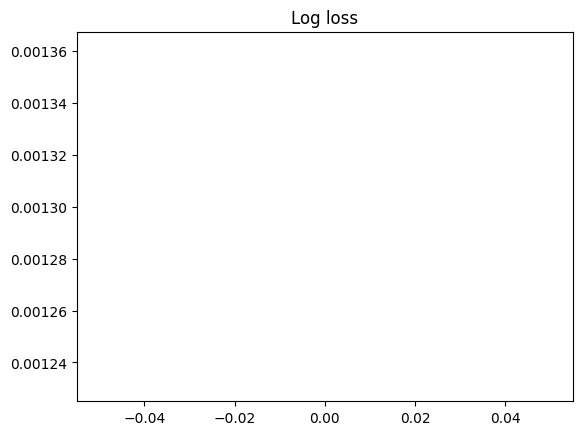

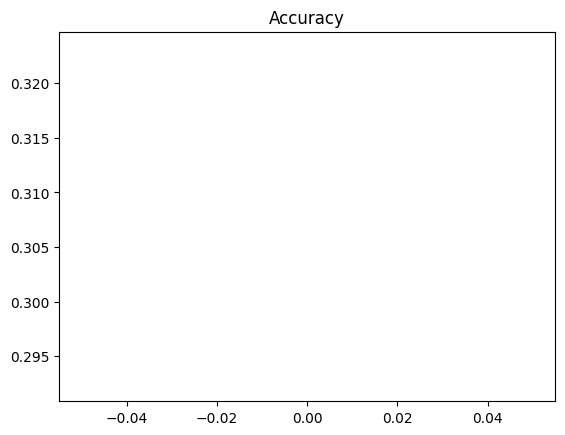

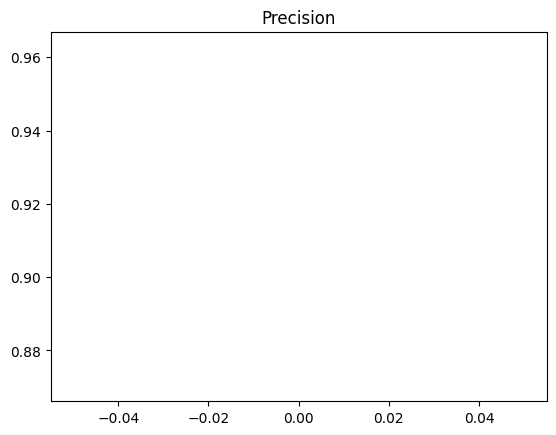

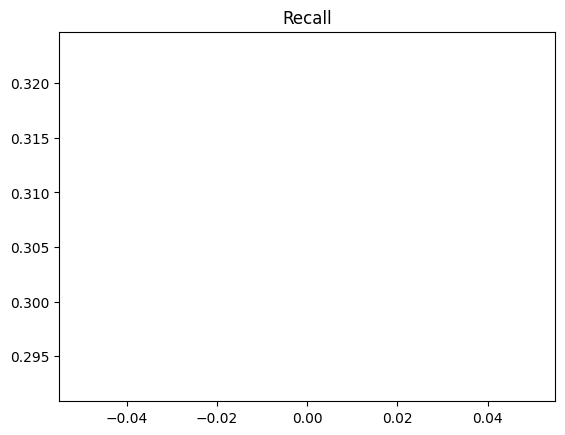

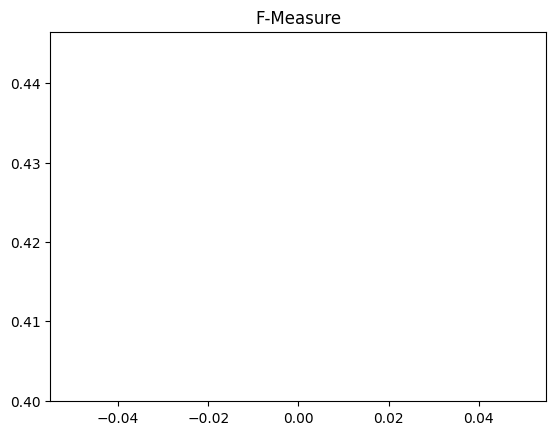

tensor([[0.0745, 0.0760, 0.1295, 0.0578, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414, 0.0414,
         0.0414, 0.0414]], grad_fn=<SelectBackward0>)
tensor([[0.2480, 0.2504, 0.2479, 0.2537]], grad_fn=<SelectBackward0>)


  0%|          | 0/514 [00:00<?, ?it/s]

1 tensor(0.4512, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


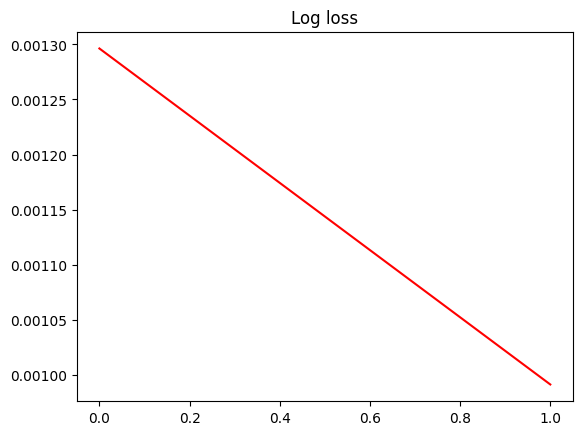

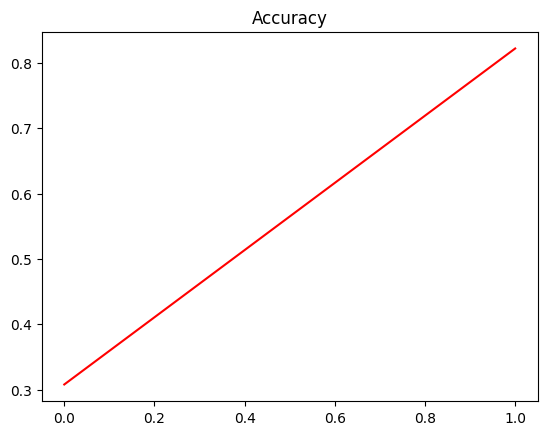

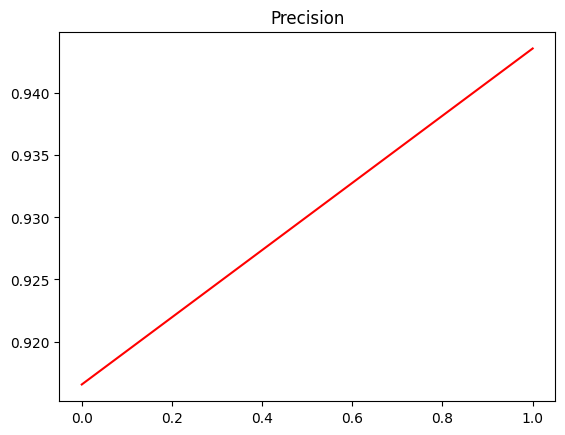

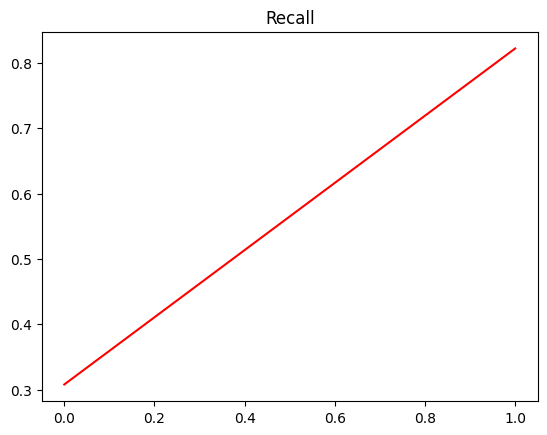

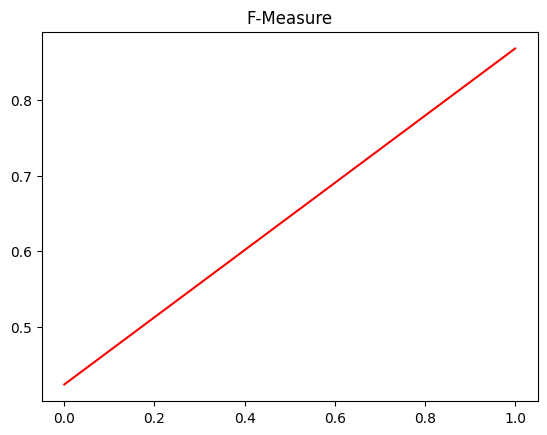

tensor([[0.0884, 0.0942, 0.2516, 0.3797, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116,
         0.0116, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116,
         0.0116, 0.0116]], grad_fn=<SelectBackward0>)
tensor([[0.2913, 0.2765, 0.1754, 0.2568]], grad_fn=<SelectBackward0>)


  0%|          | 0/514 [00:00<?, ?it/s]

2 tensor(0.3607, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


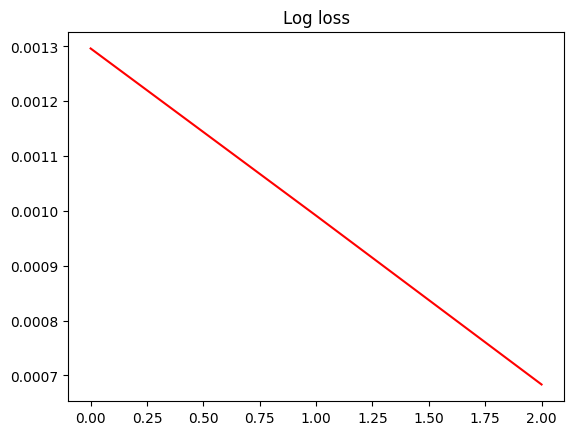

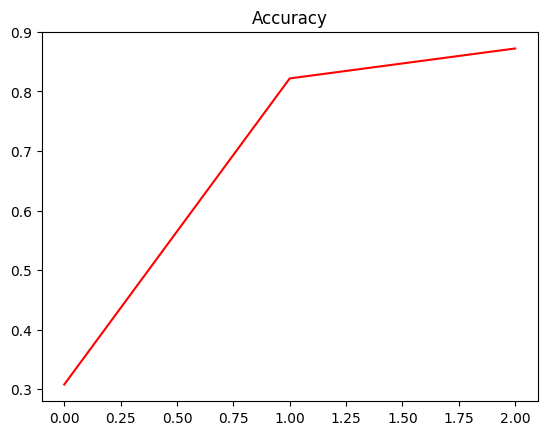

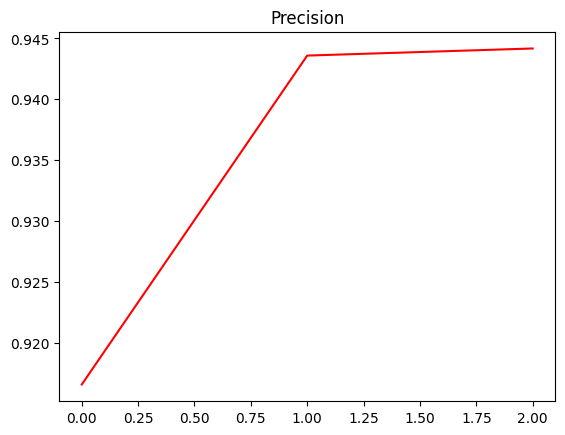

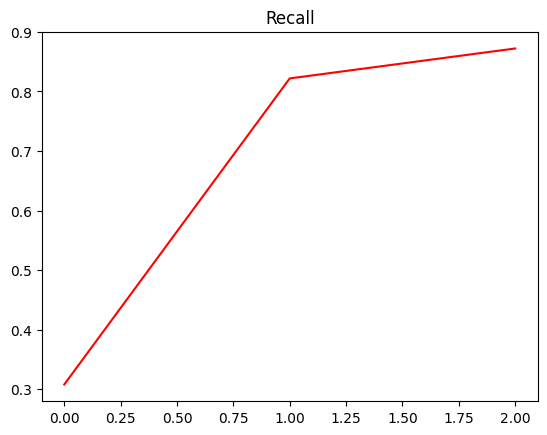

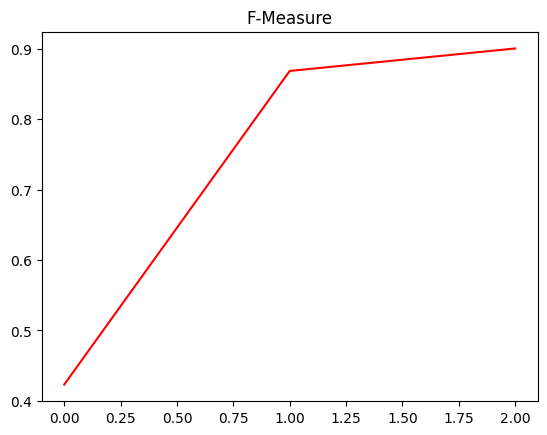

tensor([[8.3715e-02, 1.8528e-01, 7.3100e-01, 1.5517e-06, 1.4514e-15, 1.4514e-15,
         1.4514e-15, 1.4514e-15, 1.4514e-15, 1.4514e-15, 1.4514e-15, 1.4514e-15,
         1.4514e-15, 1.4514e-15, 1.4514e-15, 1.4514e-15, 1.4514e-15, 1.4514e-15,
         1.4514e-15, 1.4514e-15]], grad_fn=<SelectBackward0>)
tensor([[3.7592e-06, 6.8392e-01, 3.0223e-01, 1.3844e-02]],
       grad_fn=<SelectBackward0>)


  0%|          | 0/514 [00:00<?, ?it/s]

3 tensor(0.3317, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


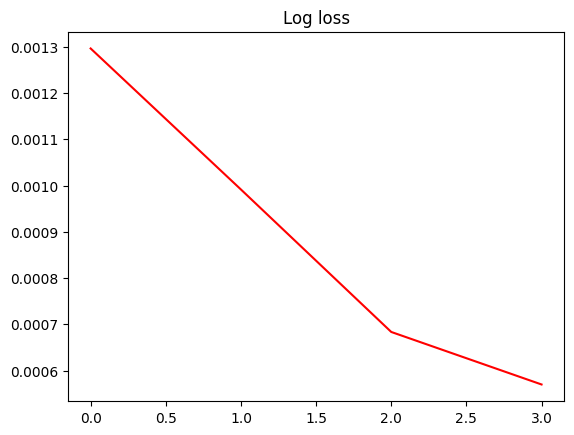

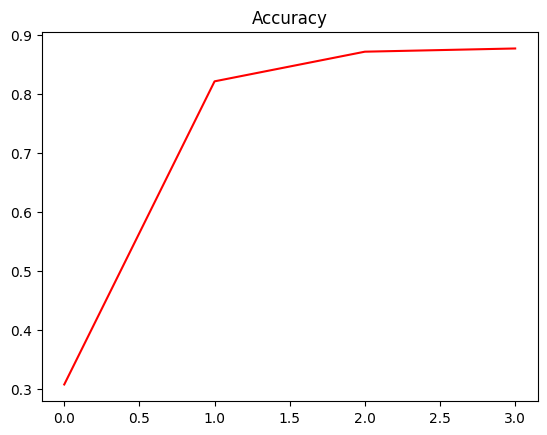

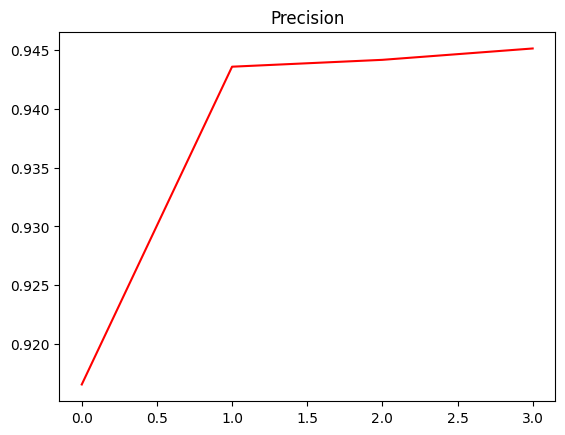

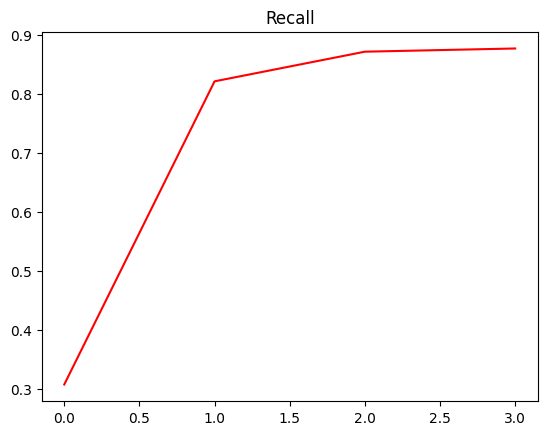

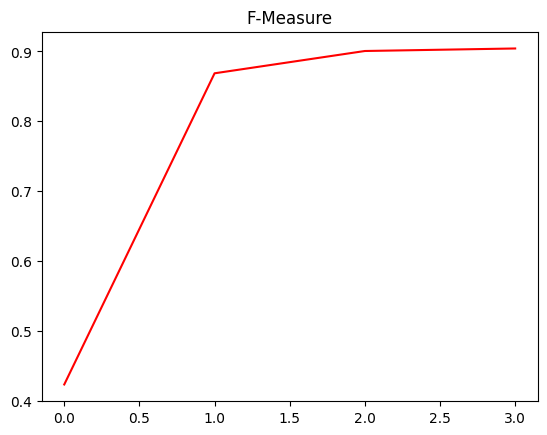

tensor([[2.4349e-02, 5.5431e-02, 9.1956e-01, 6.6163e-04, 9.5576e-11, 9.5576e-11,
         9.5576e-11, 9.5576e-11, 9.5576e-11, 9.5576e-11, 9.5576e-11, 9.5576e-11,
         9.5576e-11, 9.5576e-11, 9.5576e-11, 9.5576e-11, 9.5576e-11, 9.5576e-11,
         9.5576e-11, 9.5576e-11]], grad_fn=<SelectBackward0>)
tensor([[4.0584e-07, 2.4145e-01, 7.3854e-01, 2.0012e-02]],
       grad_fn=<SelectBackward0>)


  0%|          | 0/514 [00:00<?, ?it/s]

4 tensor(0.3108, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


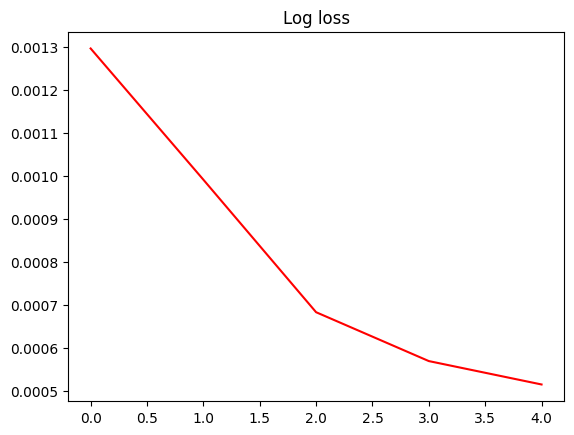

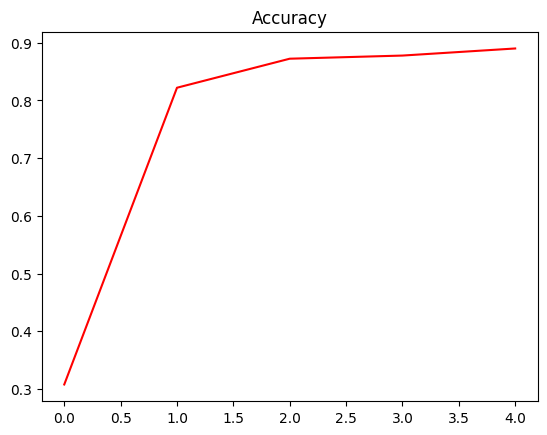

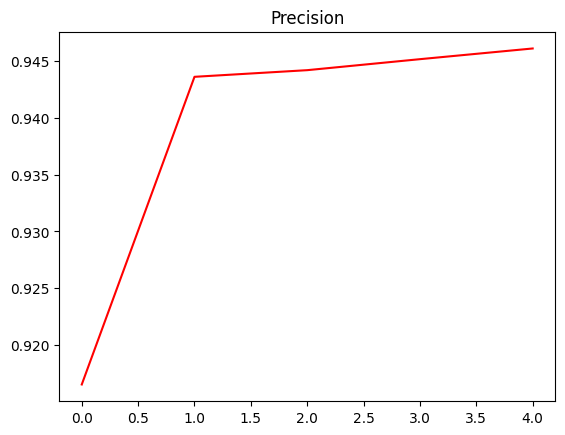

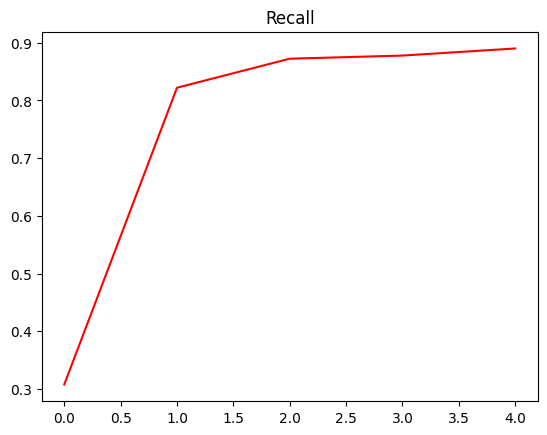

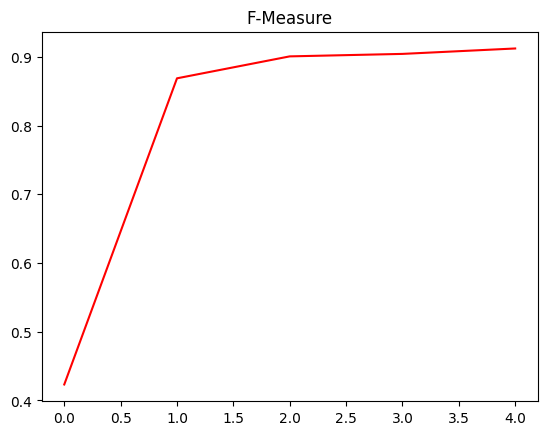

tensor([[1.3106e-01, 5.5002e-01, 3.1885e-01, 7.3711e-05, 1.3325e-10, 1.3325e-10,
         1.3325e-10, 1.3325e-10, 1.3325e-10, 1.3325e-10, 1.3325e-10, 1.3325e-10,
         1.3325e-10, 1.3325e-10, 1.3325e-10, 1.3325e-10, 1.3325e-10, 1.3325e-10,
         1.3325e-10, 1.3325e-10]], grad_fn=<SelectBackward0>)
tensor([[0.0016, 0.0532, 0.9416, 0.0036]], grad_fn=<SelectBackward0>)


  0%|          | 0/514 [00:00<?, ?it/s]

5 tensor(0.2931, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


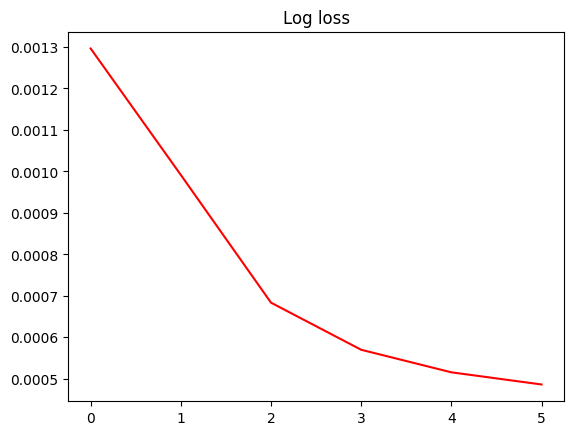

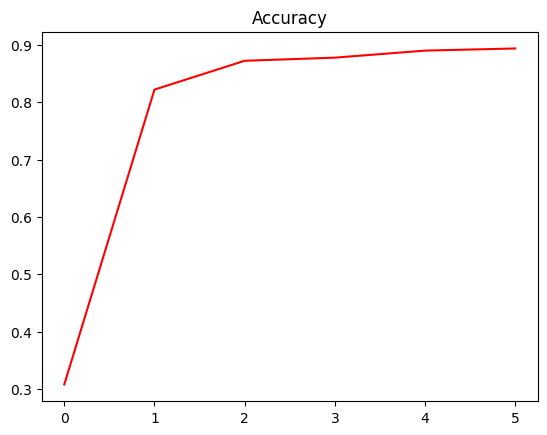

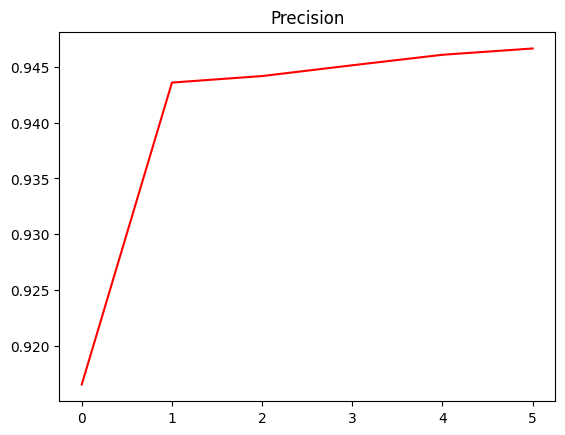

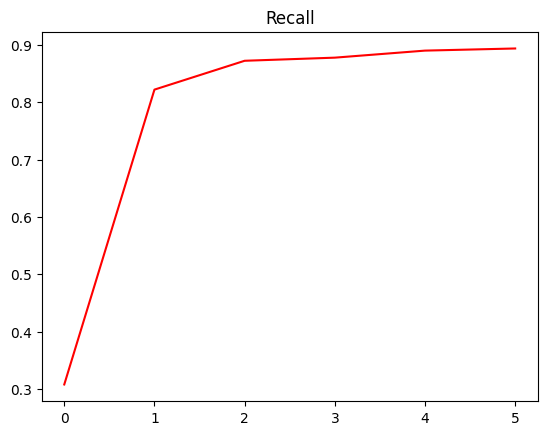

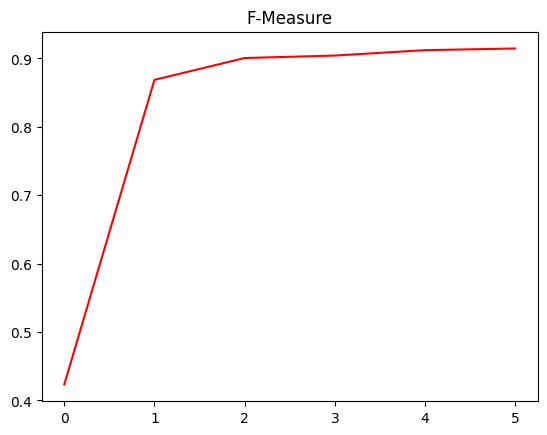

tensor([[1.2494e-01, 8.5598e-01, 1.9079e-02, 3.2599e-06, 1.5996e-13, 1.5996e-13,
         1.5996e-13, 1.5996e-13, 1.5996e-13, 1.5996e-13, 1.5996e-13, 1.5996e-13,
         1.5996e-13, 1.5996e-13, 1.5996e-13, 1.5996e-13, 1.5996e-13, 1.5996e-13,
         1.5996e-13, 1.5996e-13]], grad_fn=<SelectBackward0>)
tensor([[1.3943e-02, 8.1403e-04, 9.8524e-01, 5.0500e-07]],
       grad_fn=<SelectBackward0>)


  0%|          | 0/514 [00:00<?, ?it/s]

6 tensor(0.2847, grad_fn=<BinaryCrossEntropyBackward0>) lr : 0.01


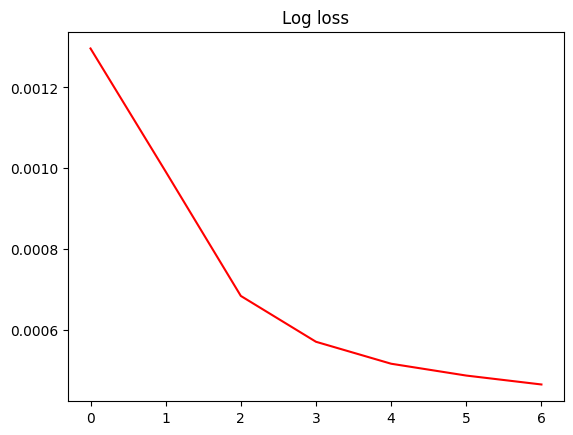

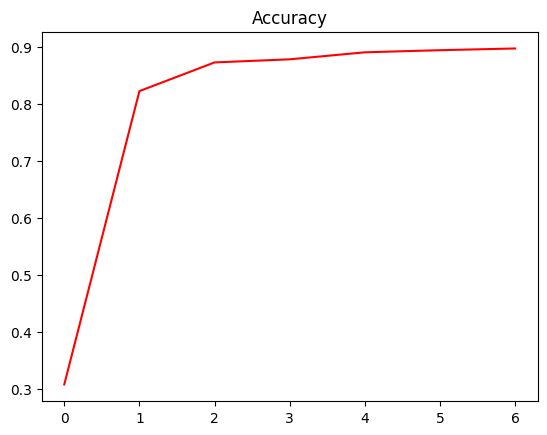

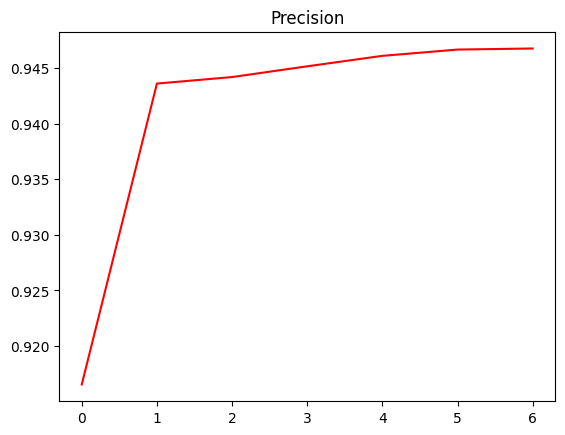

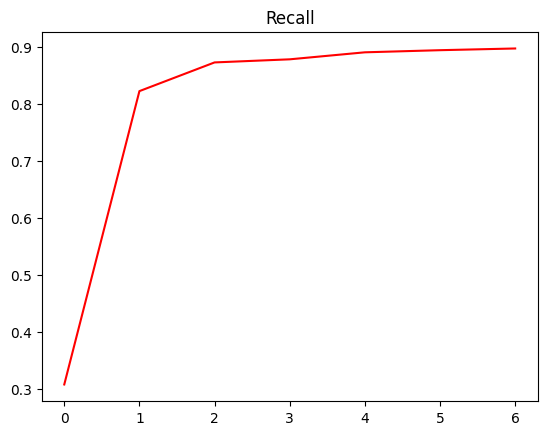

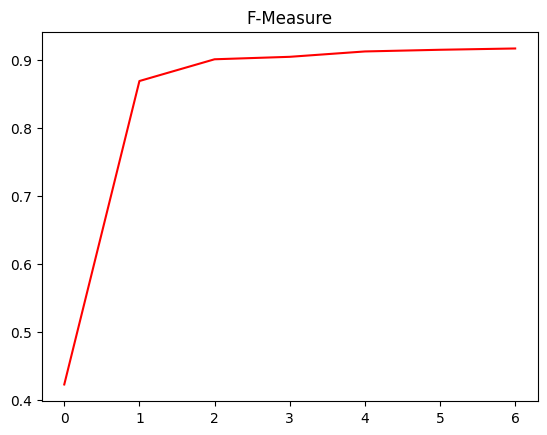

tensor([[1.2229e-01, 8.7648e-01, 1.2332e-03, 1.3911e-08, 4.9786e-15, 4.9786e-15,
         4.9786e-15, 4.9786e-15, 4.9786e-15, 4.9786e-15, 4.9786e-15, 4.9786e-15,
         4.9786e-15, 4.9786e-15, 4.9786e-15, 4.9786e-15, 4.9786e-15, 4.9786e-15,
         4.9786e-15, 4.9786e-15]], grad_fn=<SelectBackward0>)
tensor([[1.2713e-02, 1.2233e-03, 9.8606e-01, 2.6604e-06]],
       grad_fn=<SelectBackward0>)
Accuracy: 0.8966936383928571
Precision: 0.9467453925654923
Recall: 0.8966936383928571
F-Measure: 0.9165546736820108
AUC: 0.778110197006503


c:\Users\pim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\npyio.py:521: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
c:\Users\pim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [3]:

alpha = 0.01
beta1 = 0.90
beta2 = 0.98
epsilon = 1e-9
EPOCHS = 7
number_of_batches = 515

model = Swan(batchsize, sequence, touchpoints, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=alpha, betas=(beta1, beta2), eps=epsilon)
lossfn = nn.BCELoss()

epoch_loss_list = []
accuracy_list = []
precision_list = []
recall_list = []
F_measure_list = []
AUC_list = []
precision_list_unweighted = []
recall_list_unweighted = []
F_measure_list_unweighted = []
AUC_list_unweighted = []
test_output_list = []
attention_weights_1_list = []
attention_weights_2_list = []
attention_weights_3_list = []
attention_weights_4_list = []
vl_list = []
out_list = []
gradient_norm_list = []



#____________________________________________________________________________________________________________________________________________________________________________________
model.train()
for epoch in range(EPOCHS): # 3 full passes over the data
    model.train()
    epoch_loss = 0
    gradient_norms = []  
    
    attention_weights1_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
    attention_weights2_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
    attention_weights3_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
    attention_weights4_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
    vl_concat = torch.empty((number_of_batches-1), 1024, 1, 4)
    out_concat = torch.empty((number_of_batches-1), 1, 1024)

    
    for data in tqdm(range(number_of_batches-1), leave=False):
        model.zero_grad()  

        Train_inp = torch.unsqueeze(batch_train[data][:, :, 1:], dim = 0).to(device).float()
        y_true = torch.unsqueeze(batch_train[data][:, 0, 0], dim = 0).to(device).float()
        
        out,vl,attention_weights1,attention_weights2,attention_weights3,attention_weights4 = model.forward(Train_inp)
 
        loss = lossfn(out, y_true)
        # print(loss)
        
        loss.backward( retain_graph=True) 
        optimizer.step() 
        
        epoch_loss += loss.item() * y_true.shape[0] / 287145
        
        #Create list of attention weights for every batch
        attention_weights1_concat[data] = attention_weights1
        attention_weights2_concat[data] = attention_weights2
        attention_weights3_concat[data] = attention_weights3
        attention_weights4_concat[data] = attention_weights4
        vl_concat[data] = vl
        out_concat[data] = out

        
        gradients = []
        for param in model.parameters():
            if param.grad is not None:
                gradients.append(param.grad.norm().item())
        gradient_norms.append(sum(gradients))
        
    average_gradient_norm = sum(gradient_norms) / len(gradient_norms)
    gradient_norm_list.append(average_gradient_norm)


    
    #Create list of attention weights for every Epoch    
    attention_weights_1_list.append(attention_weights1_concat)
    attention_weights_2_list.append(attention_weights2_concat)
    attention_weights_3_list.append(attention_weights3_concat)
    attention_weights_4_list.append(attention_weights4_concat)
    vl_list.append(vl_concat)
    out_list.append(out_concat)

    
   # Print Loss graph
    print(epoch,loss,"lr :",optimizer.param_groups[0]['lr'])
    epoch_loss_list.append(epoch_loss)
    plt.figure()
    plt.plot(np.array(epoch_loss_list), 'r')
    plt.title('Log loss')
    plt.show()
    
    model.eval()
        
    #Print accuracy graph
    test_output_list = []
    
    for data in range(len(batch_test)-1):
        test_inp = torch.unsqueeze(batch_test[data], dim = 0).to(device).float()
        (out_test,vl,attention_weights1,attention_weights2,
        attention_weights3,attention_weights4) = model(test_inp)
        test_output_list.append(out_test)

    concat_test_output = torch.cat(test_output_list, dim=1)
    concat_test_output = torch.reshape(concat_test_output, (-1,))
    concat_test_output = concat_test_output.detach().numpy()
    pred_y_test = concat_test_output
    pred_y_test = np.where(pred_y_test > 0.5, 1, 0)

    #Take subset because we cannot enter last (smaller) batch in model
    y_test_subset = y_test[:71680]
    test_acc = accuracy_score(y_test_subset, pred_y_test)
    accuracy_list.append(test_acc)
    
    test_precision = precision_score(y_test_subset, pred_y_test, average='weighted')
    precision_list.append(test_precision)
    
    test_recall = recall_score(y_test_subset, pred_y_test, average='weighted')
    recall_list.append(test_recall)
    
    test_f_measure = f1_score(y_test_subset, pred_y_test, average='weighted')
    F_measure_list.append(test_f_measure)
    
    test_AUC = roc_auc_score(y_test_subset, pred_y_test, average='weighted')
    AUC_list.append(test_AUC)
    
    test_precision_unw = precision_score(y_test_subset, pred_y_test)
    precision_list_unweighted.append(test_precision_unw)
    
    test_recall_unw = recall_score(y_test_subset, pred_y_test)
    recall_list_unweighted.append(test_recall_unw)
    
    test_f_measure_unw = f1_score(y_test_subset, pred_y_test)
    F_measure_list_unweighted.append(test_f_measure_unw)
    
    test_AUC_unw = roc_auc_score(y_test_subset, pred_y_test)
    AUC_list_unweighted.append(test_AUC_unw)  
    
    
    
    plt.figure()
    plt.plot(np.array(accuracy_list), 'r')
    plt.title('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(np.array(precision_list), 'r')
    plt.title('Precision')
    plt.show()
    
    plt.figure()
    plt.plot(np.array(recall_list), 'r')
    plt.title('Recall')
    plt.show()
    
    plt.figure()
    plt.plot(np.array(F_measure_list), 'r')
    plt.title('F-Measure')
    plt.show()
    
    print(attention_weights_1_list[epoch][0][412])
    print(vl_list[epoch][0][412])
    
    
#batch_train[0][412][19] has length 20. 699, 988 also   
#for i in range(1024):
 #   if batch_train[0][i][19][1] != 0:
  #      print(i)
        

model.eval()
        
test_output_list = []



for data in range(len(batch_test)-1):
    test_inp = torch.unsqueeze(batch_test[data], dim = 0).to(device).float()
    (out_test,vl,attention_weights1,attention_weights2,
     attention_weights3,attention_weights4) = model(test_inp)
    test_output_list.append(out_test)

concat_test_output = torch.cat(test_output_list, dim=1)
concat_test_output = torch.reshape(concat_test_output, (-1,))
concat_test_output = concat_test_output.detach().numpy()
pred_y_test = concat_test_output
pred_y_test = np.where(pred_y_test > 0.5, 1, 0)

#Take subset because we cannot enter last (smaller) batch in model
y_test_subset = y_test[:71680]

test_acc = accuracy_score(y_test_subset, pred_y_test)
print("Accuracy:", test_acc)

# Precision (weighted to account for class imbalance)
test_precision = precision_score(y_test_subset, pred_y_test, average='weighted')
print("Precision:", test_precision)

# Recall (weighted to account for class imbalance)
test_recall = recall_score(y_test_subset, pred_y_test, average='weighted')
print("Recall:", test_recall)

# F-measure
test_f_measure = f1_score(y_test_subset, pred_y_test, average='weighted')
print("F-Measure:", test_f_measure)

#AUC
test_AUC = roc_auc_score(y_test_subset, pred_y_test, average='weighted')
print("AUC:", test_AUC)

np.save(r"C:\Users\pim\Downloads\batch_train929.pt", batch_train)
np.save(r"C:\Users\pim\Downloads\batch_test929.pt", batch_test)
np.save(r"C:\Users\pim\Downloads\y_test929", y_test)
torch.save(model.state_dict(), r"C:\Users\pim\Downloads\model_77acc.pt")